# Implementazione con Cross-Validation Stratificata

In questa sezione, il dataset viene suddiviso in due parti principali: 

1. **Training Set (80%)**: Utilizzato per addestrare e validare i modelli. All'interno di questo set, viene applicata una **Stratified 3-Fold Cross-Validation**, che garantisce che ogni fold mantenga la stessa distribuzione delle classi del dataset originale. Questo approccio consente di valutare le performance del modello in maniera più robusta, riducendo la dipendenza dalla specifica divisione del training set.

2. **Test Set (20%)**: Separato dal processo di training e validazione, questo set rimane completamente indipendente ed è utilizzato solo per il test finale dei modelli, garantendo una valutazione imparziale delle loro performance. 

## Importazione librerie

In [1]:
# Importazione delle librerie necessarie
import warnings
warnings.filterwarnings("ignore")  # Disattivazione di tutti gli avvisi (WARNING)

# Librerie principali per la gestione dei dati e la visualizzazione
import numpy as np                  
import pandas as pd                 
import matplotlib.pyplot as plt    
import seaborn as sns    

# Librerie per preprocessing, modellazione e metriche
from sklearn.preprocessing import StandardScaler  
from sklearn.utils import class_weight          
from sklearn.decomposition import PCA            
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics                     
from sklearn.metrics import (confusion_matrix,  
                             f1_score)          

# Impostazione dei colori per i grafici utilizzando la colormap "viridis"
colors = plt.cm.viridis([0.1, 0.3, 0.5, 0.7, 0.9])  # 5 colori diversi (5 classi) equidistanti

## Caricamento Dataframes

In [2]:
# Caricamento dei file CSV contenenti le caratteristiche calcolate
statistical_df = pd.read_csv("statistical_features.csv")  
texture_df = pd.read_csv("texture_features.csv")          
edge_df = pd.read_csv("edge_features.csv")                
physiological_df = pd.read_csv("physiological_features.csv")  

# Merge dei DataFrame
# Concatenazione dei DataFrame lungo l'asse delle colonne (axis=1)
# Viene mantenuta una sola colonna "label"
all_df = pd.concat([statistical_df, texture_df, edge_df, physiological_df], axis=1)

# Rimozione delle colonne duplicate (più colonne "label")
all_df = all_df.loc[:, ~all_df.columns.duplicated()]  # Selezione solo delle colonne univoche

## Prima Riduzione delle Feature

Dallo script precedente è emerso che la migliore combinazione di feature è quella che utilizza **tutte le tipologie di feature** (statistical, texture, edge, physiological), ma **escludendo le patch non rilevanti**. Questa configurazione comprende **127 feature**, dimostratesi efficaci per il task di classificazione.

In questo script si utilizza esclusivamente questa configurazione di feature per tutte le analisi successive, evitando ulteriori combinazioni di feature che non hanno mostrato miglioramenti significativi nelle performance.

In [3]:
# Eliminazione delle feature calcolate su patch che non contengono la giunzione del ginocchio.
# Si mantengono solo le feature che contengono nel nome i numeri 5, 6, 8, 9, 10, 11 e la colonna "label".

# Filtraggio delle feature rilevanti dai DataFrame
statistical_df_reduced = statistical_df.filter(regex=r'(5$|6$|8$|9$|10$|11$|label)')  
texture_df_reduced = texture_df.filter(regex=r'(5$|6$|8$|9$|10$|11$|label)')        
edge_df_reduced = edge_df.filter(regex=r'(5$|6$|8$|9$|10$|11$|label)')               

# Rimozione delle feature non necessarie (non filtrate precedentemente con la regex)
# Feature statistiche
statistical_df_reduced = statistical_df_reduced.drop(
    columns=['mean_patch_15', 'variance_patch_15', 'skewness_patch_15', 'kurtosis_patch_15']
)

# Feature testurali
texture_df_reduced = texture_df_reduced.drop(
    columns=['contrast_patch_15', 'dissimilarity_patch_15', 'homogeneity_patch_15',
             'energy_patch_15', 'correlation_patch_15',
             'lbp_hist_0_patch_15', 'lbp_hist_1_patch_15', 'lbp_hist_2_patch_15',
             'lbp_hist_3_patch_15', 'lbp_hist_4_patch_15', 'lbp_hist_5_patch_15',
             'lbp_hist_6_patch_15', 'lbp_hist_7_patch_15', 'lbp_hist_8_patch_15']
)

# Feature relative ai bordi
edge_df_reduced = edge_df_reduced.drop(
    columns=['mean_gradient_15', 'edge_density15']
)

# Unione dei DataFrame ridotti
# Concatenazione di tutte le feature filtrate e delle feature fisiologiche
all_df_reduced = pd.concat([statistical_df_reduced, texture_df_reduced, edge_df_reduced, physiological_df], axis=1)

# Rimozione delle colonne duplicate (più colonne "label")
all_df_reduced = all_df_reduced.loc[:, ~all_df_reduced.columns.duplicated()]  # Selezione solo delle colonne univoche

## Split Training Set e Test Set

Il dataset viene inizialmente suddiviso in **80% training set** e **20% test set**.  
La suddivisione del test set consente di ottenere un **set indipendente e imparziale** per la valutazione finale delle performance del modello.  

Successivamente, il **training set** verrà utilizzato per eseguire una **3-fold cross-validation stratificata**.

In [4]:
X = all_df_reduced.drop(columns=['label'])
y = all_df_reduced['label']

# Divisione in training e test set
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardizzazione: calcola la media e la deviazione standard solo sul training set
scaler = StandardScaler()
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test_reduced = scaler.transform(X_test_reduced)

## Class unbalance

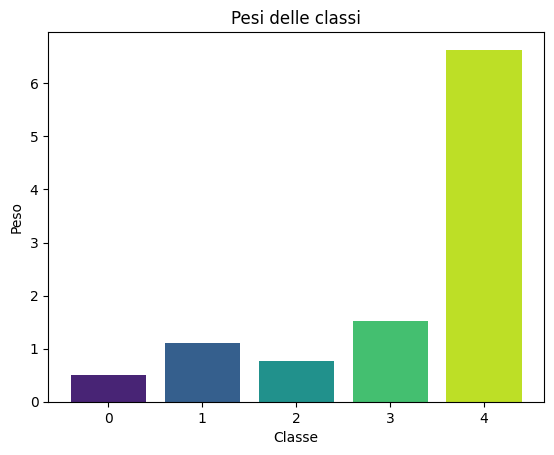

Pesi delle classi:
{0: 0.5074878444084279, 1: 1.1056497175141242, 2: 0.759262851600388, 3: 1.5214771622934888, 4: 6.633898305084746}


In [5]:
# Calcolo dei pesi per le classi utilizzando la funzione compute_class_weight
# I pesi vengono calcolati in modo bilanciato per tener conto delle classi sbilanciate (considerando solo il training set)
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_reduced),  # Classi uniche presenti nel training set
                                                  y=y_train_reduced)                   # Etichette del training set

# Converto i pesi calcolati in un dizionario che associa ogni classe al suo peso
class_weights = dict(zip(np.unique(y_train_reduced), class_weights))

# Visualizzazione dei pesi in un barplot
plt.bar(class_weights.keys(), class_weights.values(), color=colors)  
plt.xlabel('Classe')  
plt.ylabel('Peso')   
plt.title('Pesi delle classi') 
plt.show()  

# Stampa i pesi delle classi
print("Pesi delle classi:")
# Converto i valori numpy (np.float64) in float e le chiavi numpy (np.int64) in int
# Per rendere la stampa più leggibile
print({int(k): float(v) for k, v in class_weights.items()})

## Model Fitting and Validation senza PCA

Per la valutazione dei modelli, si utilizza la **3-fold cross-validation stratificata** sul training set. La stratificazione garantisce che la distribuzione delle classi venga preservata in ciascun fold. Ogni modello viene allenato e validato **3 volte** (per ognuna delle quali si utilizzano 2 fold per training e uno per validation)per ciascuna combinazione di iperparametri, e i risultati riportati rappresentano la **media delle metriche** (F1-score e accuratezza) calcolate sulle tre volte.  

La suddivisione in fold assicura che ogni istanza del dataset venga utilizzata almeno una volta sia come parte del training set che come parte del validation set, riducendo il rischio di overfitting agli specifici dati di training di un singolo split. Infine, viene scelto il modello con il **miglior F1-score** sulla validation tra tutte le combinazioni di iperparametri.

In [6]:
def hyperp_search(classifier, parameters, X_train, y_train):
    # Definizione di StratifiedKFold per gestire gli split
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # GridSearchCV con StratifiedKFold
    gs = GridSearchCV(classifier, parameters, cv=cv, scoring='f1_weighted', verbose=0, n_jobs=-1)
    gs.fit(X_train, y_train)
    
    # Miglior modello e parametri
    best_model = gs.best_estimator_
    best_param = gs.best_params_
    
    # F1-score medio dalla cross-validation
    f1_mean = gs.best_score_  # f1_weighted medio calcolato sui 3 fold
    
    # Inizializza le liste per tenere traccia degli F1 score e accuracy per train e val
    f1_train_scores = []
    accuracy_train_scores = []
    accuracy_val_scores = []
    f1_val_scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):  # Usa StratifiedKFold per gli split
        X_train = pd.DataFrame(X_train) # Necessario per utilizzare .iloc
        y_train = pd.Series(y_train)    # Necessario per utilizzare .iloc
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Allena il modello sul fold corrente con i migliori parametri
        classifier.set_params(**best_param)
        classifier.fit(X_train_fold, y_train_fold)
        
        # Predice sui dati di training e di validazione del fold
        y_train_pred = classifier.predict(X_train_fold)
        y_val_pred = classifier.predict(X_val_fold)
        
        # Calcola l'F1 score e l'accuratezza per il training set del fold
        f1_train_scores.append(metrics.f1_score(y_train_fold, y_train_pred, average='weighted'))
        accuracy_train_scores.append(metrics.accuracy_score(y_train_fold, y_train_pred))
        
        # Calcola l'F1 score e l'accuratezza per il validation set del fold
        f1_val_scores.append(metrics.f1_score(y_val_fold, y_val_pred, average='weighted'))
        accuracy_val_scores.append(metrics.accuracy_score(y_val_fold, y_val_pred))
    
    # Calcola la media di F1 e accuracy per il training e il validation set
    f1_train_mean = sum(f1_train_scores) / len(f1_train_scores)
    accuracy_train_mean = sum(accuracy_train_scores) / len(accuracy_train_scores)
    f1_val_mean = sum(f1_val_scores) / len(f1_val_scores)
    accuracy_val_mean = sum(accuracy_val_scores) / len(accuracy_val_scores)
    
    # Output dei risultati
    print(f"{'-'*40}")
    print(f"Classifier: {classifier}")
    print(f"Best Parameters: {best_param}")
    print(f"{'-'*40}")
    print(f"F1 Score (Training Mean): {f1_train_mean:.3f}")
    print(f"Accuracy (Training Mean): {accuracy_train_mean:.3f}")
    print(f"F1 Score (Validation Mean): {f1_val_mean:.3f}")
    print(f"Accuracy (Validation Mean): {accuracy_val_mean:.3f}")
    print(f"{'-'*40}")

    return best_model, best_param, f1_train_mean, accuracy_train_mean, f1_val_mean, accuracy_val_mean

# Funzione di valutazione totale
def total(classifier, parameters, X_train, y_train):
    best_model, best_param, f1_train_mean, accuracy_train_mean, f1_val_mean, accuracy_val_mean = hyperp_search(classifier, parameters, X_train, y_train)
    return best_model, best_param, f1_train_mean, accuracy_train_mean, f1_val_mean, accuracy_val_mean

### Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()

parameters = {'n_estimators' : [19,20,21,22,23],
    'criterion' : ['gini'],
             'max_depth' : [4,5,6,7,8,9,10], 
             'min_samples_split' : [2,3,4],
              'min_samples_leaf' : [4,5,6],
              'class_weight': [class_weights]
             }

# Ricerca degli iperparametri e cross-validation
best_model_RF, best_param_RF, f1_train_mean_RF, accuracy_train_mean_RF, f1_val_mean_RF, accuracy_val_mean_RF = total(classifier, parameters, X_train_reduced, y_train_reduced)

----------------------------------------
Classifier: RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5074878444084279),
                                     np.int64(1): np.float64(1.1056497175141242),
                                     np.int64(2): np.float64(0.759262851600388),
                                     np.int64(3): np.float64(1.5214771622934888),
                                     np.int64(4): np.float64(6.633898305084746)},
                       max_depth=10, min_samples_leaf=4, n_estimators=21)
Best Parameters: {'class_weight': {np.int64(0): np.float64(0.5074878444084279), np.int64(1): np.float64(1.1056497175141242), np.int64(2): np.float64(0.759262851600388), np.int64(3): np.float64(1.5214771622934888), np.int64(4): np.float64(6.633898305084746)}, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 21}
----------------------------------------
F1 Score (Training Mean): 0.743
Accuracy (Training Mean): 0

### Bagging Tree Classifier

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


classifier = BaggingClassifier()
base = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=5, min_samples_split=17, class_weight=class_weights)

parameters = {'n_estimators':[4,5,6,7,8,9],
              'estimator':[base],
              'random_state':[2]}

# Ricerca degli iperparametri e cross-validation
best_model_BC, best_param_BC, f1_train_mean_BC, accuracy_train_mean_BC, f1_val_mean_BC, accuracy_val_mean_BC = total(classifier, parameters, X_train_reduced, y_train_reduced)

----------------------------------------
Classifier: BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074878444084279),
                                                                 np.int64(1): np.float64(1.1056497175141242),
                                                                 np.int64(2): np.float64(0.759262851600388),
                                                                 np.int64(3): np.float64(1.5214771622934888),
                                                                 np.int64(4): np.float64(6.633898305084746)},
                                                   max_depth=7,
                                                   min_samples_leaf=5,
                                                   min_samples_split=17),
                  n_estimators=8, random_state=2)
Best Parameters: {'estimator': DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074878444084279),
                          

### Adaboost Tree Classifier

In [9]:
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier()
base = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=5, min_samples_split=17, class_weight=class_weights)

parameters = {'n_estimators':[4,6,7,8,9,10,11],
              'estimator':[base], 
              'learning_rate' :[0.5,0.6,0.7,0.8,0.9,1],
              'random_state':[2],
              'algorithm':['SAMME']}

# Ricerca degli iperparametri e cross-validation
best_model_AB, best_param_AB, f1_train_mean_AB, accuracy_train_mean_AB, f1_val_mean_AB, accuracy_val_mean_AB = total(classifier, parameters, X_train_reduced, y_train_reduced)

----------------------------------------
Classifier: AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074878444084279),
                                                                  np.int64(1): np.float64(1.1056497175141242),
                                                                  np.int64(2): np.float64(0.759262851600388),
                                                                  np.int64(3): np.float64(1.5214771622934888),
                                                                  np.int64(4): np.float64(6.633898305084746)},
                                                    max_depth=7,
                                                    min_samples_leaf=5,
                                                    min_samples_split=17),
                   learning_rate=0.8, n_estimators=11, random_state=2)
Best Parameters: {'algorithm': 'SAMME', 'estimator': DecisionTreeClassif

### Support Vector Classifier

In [10]:
from sklearn.svm import SVC

classifier = SVC()

parameters = {"kernel":['rbf'],
              "C":[0.01,0.1,1],
              "probability":[True],
              "class_weight":[class_weights]}

# Ricerca degli iperparametri e cross-validation
best_model_SVC, best_param_SVC, f1_train_mean_SVC, accuracy_train_mean_SVC, f1_val_mean_SVC, accuracy_val_mean_SVC = total(classifier, parameters, X_train_reduced, y_train_reduced)

----------------------------------------
Classifier: SVC(C=1,
    class_weight={np.int64(0): np.float64(0.5074878444084279),
                  np.int64(1): np.float64(1.1056497175141242),
                  np.int64(2): np.float64(0.759262851600388),
                  np.int64(3): np.float64(1.5214771622934888),
                  np.int64(4): np.float64(6.633898305084746)},
    probability=True)
Best Parameters: {'C': 1, 'class_weight': {np.int64(0): np.float64(0.5074878444084279), np.int64(1): np.float64(1.1056497175141242), np.int64(2): np.float64(0.759262851600388), np.int64(3): np.float64(1.5214771622934888), np.int64(4): np.float64(6.633898305084746)}, 'kernel': 'rbf', 'probability': True}
----------------------------------------
F1 Score (Training Mean): 0.644
Accuracy (Training Mean): 0.642
F1 Score (Validation Mean): 0.448
Accuracy (Validation Mean): 0.442
----------------------------------------


## Risultati Model fitting and validation senza PCA


In [11]:
# Dataframe con modelli sulle righe e metriche sulle colonne per confrontare i modelli sul training set e sul validation set con le feature ridotte
models_metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'Bagging', 'AdaBoost', 'SVM'],
    'Mean F1 Score (Training)': [f1_train_mean_RF, f1_train_mean_BC, f1_train_mean_AB, f1_train_mean_SVC],
    'Mean F1 Score (Validation)': [f1_val_mean_RF, f1_val_mean_BC, f1_val_mean_AB, f1_val_mean_SVC],
    'Mean Accuracy (Training)': [accuracy_train_mean_RF, accuracy_train_mean_BC, accuracy_train_mean_AB, accuracy_train_mean_SVC],
    'Mean Accuracy (Validation)': [accuracy_val_mean_RF, accuracy_val_mean_BC, accuracy_val_mean_AB, accuracy_val_mean_SVC]    
})

models_metrics_df

,Model,Mean F1 Score (Training),Mean F1 Score (Validation),Mean Accuracy (Training),Mean Accuracy (Validation)
0,Random Forest,0.743338,0.408534,0.743741,0.410830
1,Bagging,0.484498,0.378420,0.496487,0.388603
2,AdaBoost,0.593919,0.392692,0.593511,0.391543
3,SVM,0.643884,0.447769,0.642118,0.442002


## Seconda Riduzione delle Feature: PCA

Da questo punto in poi, tutte le analisi e i processi seguiranno lo stesso schema dello script precedente. Tuttavia, in questo caso, verrà utilizzata la **stratified cross-validation** per la valutazione dei modelli, anziché il metodo hold-out.  

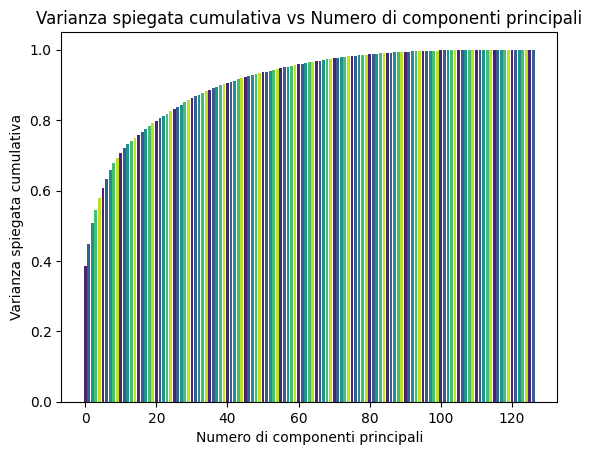

In [12]:
pca = PCA() 
X_train_reduced_pca = pca.fit_transform(X_train_reduced)
X_test_reduced_pca = pca.transform(X_test_reduced)

# Stampa della varianza spiegata per ogni componente principale
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot della varianza spiegata cumulativa
plt.bar(range(len(cumulative_variance_ratio)), cumulative_variance_ratio, color=colors)
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.title('Varianza spiegata cumulativa vs Numero di componenti principali')
plt.show()

In [13]:
# Usare solo le prime 45 componenti principali
pca = PCA(n_components=45)
X_train_reduced_pca = pca.fit_transform(X_train_reduced)
X_test_reduced_pca = pca.transform(X_test_reduced)

explained_variance_45 = np.sum(pca.explained_variance_ratio_)
print(f"Varianza spiegata dalle prime 45 componenti: {explained_variance_45:.2f}")

# Stampa delle shape di X_train, X_val e X_test ridotte e trasformate con PCA
print('Shape di X_train_reduced_pca:')
print(X_train_reduced_pca.shape)

print('Shape di X_test_reduced_pca:')
print(X_test_reduced_pca.shape)

Varianza spiegata dalle prime 45 componenti: 0.92
Shape di X_train_reduced_pca:
(7828, 45)
Shape di X_test_reduced_pca:
(1958, 45)


## Model fitting and validation con PCA

### Ranfom Forest

In [14]:
classifier = RandomForestClassifier()

parameters = {'n_estimators' : [19,20,21,22,23],
    'criterion' : ['gini'],
             'max_depth' : [4,5,6,7,8,9,10], 
             'min_samples_split' : [2,3,4],
              'min_samples_leaf' : [4,5,6],
              'class_weight': [class_weights]
             }

# Ricerca degli iperparametri e valutazione del modello sul dataset trasformato con PCA (45 componenti principali)
best_model_RF_pca, best_param_RF_pca, f1_train_mean_RF_pca, accuracy_train_mean_RF_pca, f1_val_mean_RF_pca, accuracy_val_mean_RF_pca = total(classifier, parameters, X_train_reduced_pca, y_train_reduced)

----------------------------------------
Classifier: RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5074878444084279),
                                     np.int64(1): np.float64(1.1056497175141242),
                                     np.int64(2): np.float64(0.759262851600388),
                                     np.int64(3): np.float64(1.5214771622934888),
                                     np.int64(4): np.float64(6.633898305084746)},
                       max_depth=10, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=21)
Best Parameters: {'class_weight': {np.int64(0): np.float64(0.5074878444084279), np.int64(1): np.float64(1.1056497175141242), np.int64(2): np.float64(0.759262851600388), np.int64(3): np.float64(1.5214771622934888), np.int64(4): np.float64(6.633898305084746)}, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 21}
----------------------------------------
F1 Score (Train

### Bagging Tree Classifier

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


classifier = BaggingClassifier()
base = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=5, min_samples_split=17, class_weight=class_weights)

parameters = {'n_estimators':[4,5,6,7,8,9],
              'estimator':[base],
              'random_state':[2]}

# Ricerca degli iperparametri e valutazione del modello sul dataset trasformato con PCA (45 componenti principali)
best_model_BC_pca, best_param_BC_pca, f1_train_mean_BC_pca, accuracy_train_mean_BC_pca, f1_val_mean_BC_pca, accuracy_val_mean_BC_pca = total(classifier, parameters, X_train_reduced_pca, y_train_reduced)

----------------------------------------
Classifier: BaggingClassifier(estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074878444084279),
                                                                 np.int64(1): np.float64(1.1056497175141242),
                                                                 np.int64(2): np.float64(0.759262851600388),
                                                                 np.int64(3): np.float64(1.5214771622934888),
                                                                 np.int64(4): np.float64(6.633898305084746)},
                                                   max_depth=7,
                                                   min_samples_leaf=5,
                                                   min_samples_split=17),
                  n_estimators=9, random_state=2)
Best Parameters: {'estimator': DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074878444084279),
                          

### Adaboost Tree Classifier

In [16]:
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier()
base = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=5, min_samples_split=17, class_weight=class_weights)

parameters = {'n_estimators':[4,6,7,8,9,10,11],
              'estimator':[base], 
              'learning_rate' :[0.5,0.6,0.7,0.8,0.9,1],
              'random_state':[2],
              'algorithm':['SAMME']}

# Ricerca degli iperparametri e valutazione del modello sul dataset trasformato con PCA (45 componenti principali)
best_model_AB_pca, best_param_AB_pca, f1_train_mean_AB_pca, accuracy_train_mean_AB_pca, f1_val_mean_AB_pca, accuracy_val_mean_AB_pca = total(classifier, parameters, X_train_reduced_pca, y_train_reduced)

----------------------------------------
Classifier: AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight={np.int64(0): np.float64(0.5074878444084279),
                                                                  np.int64(1): np.float64(1.1056497175141242),
                                                                  np.int64(2): np.float64(0.759262851600388),
                                                                  np.int64(3): np.float64(1.5214771622934888),
                                                                  np.int64(4): np.float64(6.633898305084746)},
                                                    max_depth=7,
                                                    min_samples_leaf=5,
                                                    min_samples_split=17),
                   learning_rate=0.6, n_estimators=11, random_state=2)
Best Parameters: {'algorithm': 'SAMME', 'estimator': DecisionTreeClassif

### Support Vector Classifier

In [17]:
from sklearn.svm import SVC

classifier = SVC()

parameters = {"kernel":['rbf'],
              "C":[0.01,0.1,1],
              "probability":[True],
              "class_weight":[class_weights]}

# Ricerca degli iperparametri e valutazione del modello sul dataset trasformato con PCA (45 componenti principali)
best_model_SVC_pca, best_param_SVC_pca, f1_train_mean_SVC_pca, accuracy_train_mean_SVC_pca, f1_val_mean_SVC_pca, accuracy_val_mean_SVC_pca = total(classifier, parameters, X_train_reduced_pca, y_train_reduced)

----------------------------------------
Classifier: SVC(C=1,
    class_weight={np.int64(0): np.float64(0.5074878444084279),
                  np.int64(1): np.float64(1.1056497175141242),
                  np.int64(2): np.float64(0.759262851600388),
                  np.int64(3): np.float64(1.5214771622934888),
                  np.int64(4): np.float64(6.633898305084746)},
    probability=True)
Best Parameters: {'C': 1, 'class_weight': {np.int64(0): np.float64(0.5074878444084279), np.int64(1): np.float64(1.1056497175141242), np.int64(2): np.float64(0.759262851600388), np.int64(3): np.float64(1.5214771622934888), np.int64(4): np.float64(6.633898305084746)}, 'kernel': 'rbf', 'probability': True}
----------------------------------------
F1 Score (Training Mean): 0.592
Accuracy (Training Mean): 0.590
F1 Score (Validation Mean): 0.431
Accuracy (Validation Mean): 0.425
----------------------------------------


## Risultati Model Fitting and Validation con PCA

Anche in questo caso (utilizzando un diverso split), i risultati mostrano che l'utilizzo della PCA non comporta cambiamenti significativi nelle performance complessive dei modelli.

Dato che la PCA riduce la dimensionalità del dataset migliorando l'efficienza computazionale e garantendo una maggiore stabilità nelle metriche, si decide di adottarla come metodo definitivo per la selezione delle feature in questo script.

In [18]:
# Dataframe con modelli sulle righe e metriche sulle colonne per confrontare i modelli sul training set e sul validation set con la PCA (45 componenti principali)
models_metrics_pca_df = pd.DataFrame({
    'Model': ['Random Forest_PCA', 'Bagging_PCA', 'AdaBoost_PCA', 'SVM_PCA'],
    'Mean F1 Score (Training)': [f1_train_mean_RF_pca, f1_train_mean_BC_pca, f1_train_mean_AB_pca, f1_train_mean_SVC_pca],
    'Mean F1 Score (Validation)': [f1_val_mean_RF_pca, f1_val_mean_BC_pca, f1_val_mean_AB_pca, f1_val_mean_SVC_pca],
    'Mean Accuracy (Training)': [accuracy_train_mean_RF_pca, accuracy_train_mean_BC_pca, accuracy_train_mean_AB_pca, accuracy_train_mean_SVC_pca],
    'Mean Accuracy (Validation)': [accuracy_val_mean_RF_pca, accuracy_val_mean_BC_pca, accuracy_val_mean_AB_pca, accuracy_val_mean_SVC_pca]    
})

models_metrics_pca_df


,Model,Mean F1 Score (Training),Mean F1 Score (Validation),Mean Accuracy (Training),Mean Accuracy (Validation)
0,Random Forest_PCA,0.706314,0.378920,0.706886,0.378512
1,Bagging_PCA,0.502471,0.353421,0.504599,0.350536
2,AdaBoost_PCA,0.561129,0.368440,0.560105,0.364077
3,SVM_PCA,0.592041,0.431405,0.589869,0.425140


In [19]:
models_metrics_df = pd.concat([models_metrics_df, models_metrics_pca_df], axis=0)

models_metrics_df

,Model,Mean F1 Score (Training),Mean F1 Score (Validation),Mean Accuracy (Training),Mean Accuracy (Validation)
0,Random Forest,0.743338,0.408534,0.743741,0.410830
1,Bagging,0.484498,0.378420,0.496487,0.388603
2,AdaBoost,0.593919,0.392692,0.593511,0.391543
3,SVM,0.643884,0.447769,0.642118,0.442002
0,Random Forest_PCA,0.706314,0.378920,0.706886,0.378512
1,Bagging_PCA,0.502471,0.353421,0.504599,0.350536
2,AdaBoost_PCA,0.561129,0.368440,0.560105,0.364077
3,SVM_PCA,0.592041,0.431405,0.589869,0.425140


## Testing

In questa fase, i migliori modelli selezionati per ogni classificatore (Random Forest, Bagging Classifier, AdaBoost e SVC) vengono testati sul test set.

Utilizzando lo **stratified cross-validation** durante la fase di training e validazione, si è osservato un minore rischio di overfitting rispetto all'approccio basato sull'hold-out. Questo è dovuto al fatto che ogni istanza nel dataset è stata utilizzata sia per il training che per la validazione in modo equilibrato e ripetuto.

I risultati ottenuti sul test set sono rimasti simili rispetto all'approccio nello script precedente, ma si è arrivati alla conclusione che i migliori modelli sono quelli allenati utilizzando le **45 principali componenti** ottenute tramite PCA e validati con **stratified cross-validation**. Questo approccio ha dimostrato di mantenere prestazioni medie e di ridurre il rischio di overfitting, risultando quindi la soluzione preferibile per l'allenamento e la validazione del modello.

In [20]:
# Funzione per la creazione della confusion matrix (predicted sulle colonne, actual sulle righe)
def print_confusion_matrix(model, X, y, title):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    print(f'Confusion Matrix: {title}')
    print(cm)
    print('\n') 
    
# Stampa della confusion matrix per il modello Random Forest con PCA sul test set
print_confusion_matrix(best_model_RF_pca, X_test_reduced_pca, y_test_reduced, 'Random Forest PCA')

# Stampa della confusion matrix per il modello Bagging con PCA sul test set
print_confusion_matrix(best_model_BC_pca, X_test_reduced_pca, y_test_reduced, 'Bagging PCA')

# Stampa della confusion matrix per il modello AdaBoost con PCA sul test set
print_confusion_matrix(best_model_AB_pca, X_test_reduced_pca, y_test_reduced, 'AdaBoost PCA')

# Stampa della confusion matrix per il modello SVC con PCA sul test set
print_confusion_matrix(best_model_SVC_pca, X_test_reduced_pca, y_test_reduced, 'SVC PCA')

Confusion Matrix: Random Forest PCA
[[370 193 137  68   4]
 [138  78  82  53   3]
 [151 109 145  99  12]
 [ 31  35  54 121  16]
 [  1   1   5  27  25]]


Confusion Matrix: Bagging PCA
[[332 193 122 115  10]
 [109 108  66  66   5]
 [129 129 126 112  20]
 [ 29  32  50 106  40]
 [  1   1   4  19  34]]


Confusion Matrix: AdaBoost PCA
[[295 176 252  46   3]
 [110  90 118  33   3]
 [109 109 209  79  10]
 [ 30  25  83  94  25]
 [  1   3   8  20  27]]


Confusion Matrix: SVC PCA
[[406 212 111  41   2]
 [126 115  74  38   1]
 [122 112 185  93   4]
 [ 21  25  67 120  24]
 [  1   0   0  23  35]]




In [22]:
# funzione per il test del modello
def test_model(model, X, y):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred, average='weighted')
    accuracy = metrics.accuracy_score(y, y_pred)
    return f1, accuracy

# Test del modello Random Forest con PCA sul test set
f1_test_RF_pca, accuracy_test_RF_pca = test_model(best_model_RF_pca, X_test_reduced_pca, y_test_reduced)

# Test del modello Bagging con PCA sul test set
f1_test_BC_pca, accuracy_test_BC_pca = test_model(best_model_BC_pca, X_test_reduced_pca, y_test_reduced)

# Test del modello AdaBoost con PCA sul test set
f1_test_AB_pca, accuracy_test_AB_pca = test_model(best_model_AB_pca, X_test_reduced_pca, y_test_reduced)

# Test del modello SVC con PCA sul test set
f1_test_SVC_pca, accuracy_test_SVC_pca = test_model(best_model_SVC_pca, X_test_reduced_pca, y_test_reduced)

# Dataframe con i risultati del test sui modelli con PCA (45 componenti principali)
models_test_pca_df = pd.DataFrame({
    'Model': ['Random Forest_PCA', 'Bagging_PCA', 'AdaBoost_PCA', 'SVM_PCA'],
    'F1 Score (Test)': [f1_test_RF_pca, f1_test_BC_pca, f1_test_AB_pca, f1_test_SVC_pca],
    'Accuracy (Test)': [accuracy_test_RF_pca, accuracy_test_BC_pca, accuracy_test_AB_pca, accuracy_test_SVC_pca]
})

models_test_pca_df

,Model,F1 Score (Test),Accuracy (Test)
0,Random Forest_PCA,0.380933,0.377426
1,Bagging_PCA,0.367163,0.360572
2,AdaBoost_PCA,0.371963,0.365169
3,SVM_PCA,0.446200,0.439734
